# Assignment: Naïve Bayes Classifier

In this assignment, you will implement the Naïve Bayes classifier and then compare it to the one implemented in `scikit-learn` module. The goal is to investigate the influence of Laplace correction on the classification results for the Naïve Bayes classifier.

As a sample dataset, we will use the MNIST dataset of handwritten digits quantized into vectors of length 784, where each vector element is the gray level of the corresponding picture pixel. The original pictures have dimensions 28$\times$28. All vectors contain only pixels with three possible values 0,1,2. The value 2 indicates a black pixel, 0 corresponds to a white pixel, and 1 corresponds to a gray pixel.

The file `MNIST3_dataset.npz` with the dataset can be downloaded from Moodle together with this notebook. 

In [37]:
!pip install tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [38]:
# in the load method the parameter allow_pickle must 
# be set to True for unpacking the data
npzfile = np.load('MNIST3_dataset.npz', allow_pickle=True)
npzfile.files

['X_train', 'y_train', 'X_test', 'y_test']

The arrays `X_train` and `y_train` contain training input data and true classes. The arrays `X_test` and `y_test` contain test inputs and true labels. E.g., let us inspect the 34th test sample.

True label 7


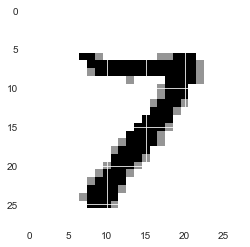

In [39]:
plt.imshow(npzfile['X_test'][34].reshape(28,28), cmap='Greys')
y_test = npzfile['y_test']
print('True label',y_test[34])

You should implement your own Naïve Bayes classifier for classifying the handwritten digits. For that, you **must not use any classifier from another toolbox or library**. You should implement the following two functions:
* `NBTrain` for training a Naïve Bayes classifier with a Laplace correction, and
* `NBClassify` for classification.

After implementing the functions, you should test your classifier on the test set of handwritten digits. Below you will find a detailed description of the functions you should implement and tests you should perform.

## Task 1: Implement the function `NBTrain()`

The first function is 

    NBTrain(Pat, PatClass, FNum, CNum, LC=0)
    
where 
* `Pat` are training patterns stored in a two-dimensional array of integers with values between 0 and `FNum-1`,
* `PatClass` are true classes of the patterns in the array `Pat`; that is `PatClass[i]` is the true class for the pattern `Pat[i]`,
* `FNum`is the number of possible values for a feature, features can have values between 0 and `FNum-1` only, we assume `FNum` $\le50$,
* `CNum` is the number classes, `PatClass` can contain only values between 0 and `CNum-1` (we assume `CNum` $\le 20$), and
* `LC` is the value of Laplace correction.

Function `NBTrain` should return a pair `(B,P)` of tables:
* `B` is a three-dimensional array, where `B[f,c,i]` is the **logarithm** of the probability that a pattern with value `f` in the feature `i` is classified into class `c`. For computing this conditional probability, you should use Laplace correction in the following form 

$$B[f,c,i] = \log\frac{\mbox{the number of patterns with classification } c \mbox{ and value } f \mbox{ in the element } i \mbox{ of the pattern} + LC}{\mbox{the number of patterns from class } c + FNum\cdot LC}$$

*  `P` is an array of log priors - **logarithms** of the estimate s of apriori probabilities for all classes (without the Laplace correction)

$$P[c] = \log \frac{\mbox{the number of patterns classified into class } c}{\mbox{the number of all patterns}}\ .$$

In [40]:
def NBTrain(Pat, PatClass, FNum, CNum, LC=0):
    B = np.zeros([FNum, CNum, Pat.shape[1]])
    P = np.zeros(CNum)
    # For every class
    for c in range(CNum):
        # patterns_class[i] = 1 if PatClass[i] == c
        patterns_class = np.where(PatClass == c, 1, 0)
        # Counting how many patterns have class c
        number_patterns_class_c = np.sum(patterns_class)
        # Computing the prior probability
        P[c] = np.log(number_patterns_class_c / Pat.shape[0])
        for f in range(FNum):
            numerator = np.sum(np.multiply((Pat == f), np.expand_dims(patterns_class, 1)), axis=0) + LC
            denominator = number_patterns_class_c + FNum * LC
            B[f,c,:] = np.log(numerator / denominator)

    return B, P

# test the function
patterns = [[1,0,0,1,2],[0,0,0,1,1],[1,0,0,1,2]]
classes = [0,0,1]
FNum = 3
CNum = 2
B, P = NBTrain(np.array(patterns),np.array(classes),FNum,CNum,LC=1)

## Task 2: Implement the function `NBClassify()`

The second function 

    NBClassify(Pat, B, P)

computes the classification of the patterns `Pat` based on tables `B` and `P` produced by the function `NBTrain` and using the method of Naïve Bayes classifier. Its parameters are
* `Pat` is a two-dimensional array of patterns (each row of `Pat` is one pattern),
* `B` is a three-dimensional array of floats - the first array computed by `NBTrain`, and
* `P` is a vector of floats - the second array computed by `NBTrain`.

The function returns a vector containing predicted classes for all patterns from `Pat`.

In the implementation, you should use a logarithm, as otherwise, the accuracy can be lost by computing products of a large number of values less than one.

In [41]:
def NBClassify(Pat, B, P):
    classification = []
    for pattern in Pat:
        # Create a vector containing the probabilities of each class
        classes = np.ones(B.shape[1])
        for i in range(len(pattern)):
            f = pattern[i]
            # Using + instead of sum because when taking the logarithm, the logarithm of the product becomes a sum of the logarithms
            classes += B[f, :, i]
        classes += P
        # taking the class with the highest log probability
        cur_class = np.argmax(classes)
        classification.append(cur_class)

    return np.array(classification)

# test the function
test = [[1,0,0,1,1], [2,0,0,1,2]]
NBClassify(test, B, P)

array([0, 0], dtype=int64)

## Task 3: Find the best classifier

1. Calculate the error of the classifier on the training set `X_train` and the test set `X_test` for different values Laplace correction values `LC` = 0, 0.001, 0.01, 0.1, 0.2, 0.4, 1, 10. Present the results in a tabular form. For which of these Laplace correction values is the error on the test set minimal?

3. Describe the errors made by your best classifier. This description should include the images of the first 10 handwritten digits on which your best classifier made an error, **together with the required and incorrect classification** of those digits.

Since the features have values 0, 1, 2, then the number of values for the features FNum = 3.
The number of classes are instead the digits from 0 to 9 and therefore CNum = 10

In [42]:
LC = [0, 0.001, 0.01, 0.1, 0.2, 0.4, 1, 10]

results = []
for l in LC:
    B_train, P_train = NBTrain(npzfile['X_train'], npzfile['y_train'], 3, 10, LC=l)
    classification = NBClassify(npzfile['X_test'], B_train, P_train)

    correct = np.sum(classification == npzfile['y_test'])
    total = npzfile['y_test'].shape[0]
    results.append([l, (1 - correct / total) * 100])

headers = ['Lambda Correction', 'Error %']
table = tabulate(results, headers, tablefmt='fancy_grid')
print(table)

C:\Users\User\AppData\Local\Temp\ipykernel_34960\3160277165.py:15: RuntimeWarning: divide by zero encountered in log
  B[f,c,:] = np.log(numerator / denominator)


╒═════════════════════╤═══════════╕
│   Lambda Correction │   Error % │
╞═════════════════════╪═══════════╡
│               0     │     15.32 │
├─────────────────────┼───────────┤
│               0.001 │     15.15 │
├─────────────────────┼───────────┤
│               0.01  │     15.2  │
├─────────────────────┼───────────┤
│               0.1   │     15.24 │
├─────────────────────┼───────────┤
│               0.2   │     15.24 │
├─────────────────────┼───────────┤
│               0.4   │     15.25 │
├─────────────────────┼───────────┤
│               1     │     15.29 │
├─────────────────────┼───────────┤
│              10     │     15.55 │
╘═════════════════════╧═══════════╛


The best classifier is the one with lambda correction equal to 0.001.
We are going to consider that for the second point of the exercise.

In [43]:
B_train, P_train = NBTrain(npzfile['X_train'], npzfile['y_train'], 3, 10, LC=0.001)
classification = NBClassify(npzfile['X_test'], B_train, P_train)

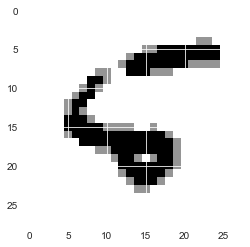

Correct class: 5
Predicted class: 4


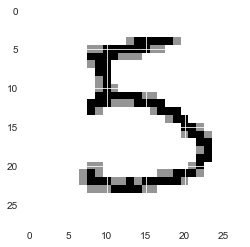

Correct class: 5
Predicted class: 3


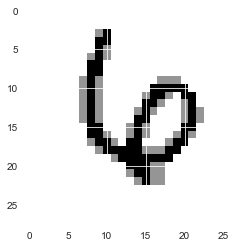

Correct class: 6
Predicted class: 4


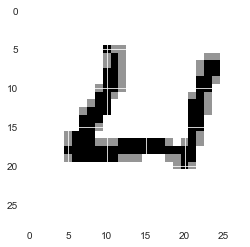

Correct class: 4
Predicted class: 0


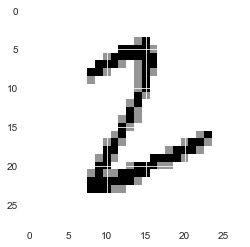

Correct class: 2
Predicted class: 3


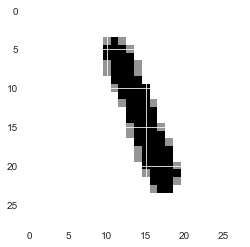

Correct class: 1
Predicted class: 3


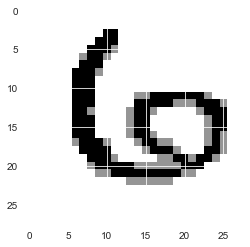

Correct class: 6
Predicted class: 2


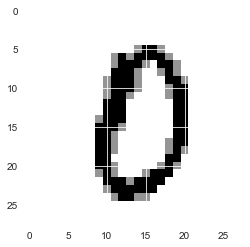

Correct class: 0
Predicted class: 8


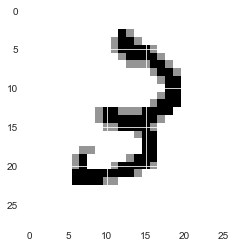

Correct class: 3
Predicted class: 2


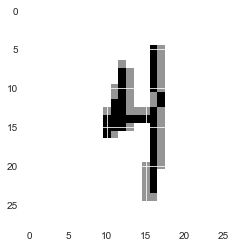

Correct class: 4
Predicted class: 9


In [44]:
# getting a vector of the positions in which a digit was misclassified
wrong_classification = classification != npzfile['y_test']
# Obtaining, in this order, pattern, true label, prediction of the first 10 wrongly classified digits
wrong = npzfile['X_test'][wrong_classification][:10]
label = npzfile['y_test'][wrong_classification][:10]
pred = classification[wrong_classification][:10]

# printing the digits and their predicted/correct class
for i in range(wrong.shape[0]):
    plt.figure()
    plt.imshow(wrong[i].reshape(28,28), cmap='Greys')
    plt.show()
    print('Correct class:', label[i])
    print('Predicted class:', pred[i])

We can see that some errors are quite serious, for example for 1, 2, 3, 6 their representation is quite clear to a human eye, with the only difference that they are tilted, rotated or translated.
This could be related to the fact that the Naive Bayes classifier only looks at every pixel independently of the surrounding ones and, most importantly, independently of the shape that these pixels are forming.
So during training the classifier will mainly learn the shapes of digits which are in the correct position with some degree of uncertainty, but it won't be able to classify correctly digits which are moved in some way.
For example, it is unlikely that a six will have some valid pixels to the left part in the training set.

The 4's here reported instead are likely to be confused so the mistake isn't too bad.

We can take for example one of the wrong digits in the test set and compare it to the learned representation of the digits from the training data.

C:\Users\User\AppData\Local\Temp\ipykernel_34960\2019938306.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


<Figure size 432x288 with 0 Axes>

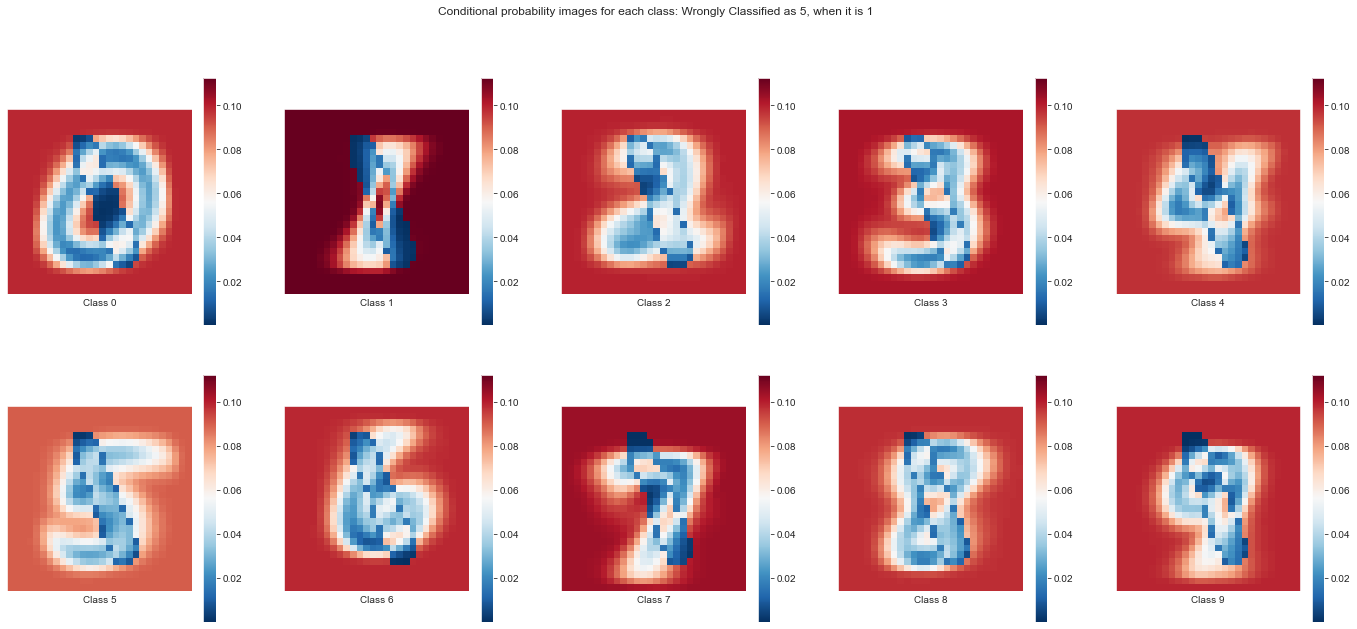

In [45]:
wrong_pattern = wrong[5]
heatmap = np.zeros(shape=(10, 28*28))

# Here we look, for every position i of the pattern, at the conditional probability of having that feature given the class.
for i in range(len(wrong_pattern)):
    f = wrong_pattern[i]
    heatmap[:, i] += B_train[f, :, i]

# Now you sum to each pixel in every class the probabilty of having the class.
for c in range(heatmap.shape[0]):
    heatmap[c, :] = heatmap[c, :] + P_train[c]

# Now heatmap is containing for every position i and every class the
# P(C | feature of wrong pattern in position i)

# Doing the exponentiation since our heatmap was using the logarithmic scale
heatmap = np.exp(heatmap)
vmax = np.max(heatmap)
vmin = np.min(heatmap)

fig = plt.figure()
plt.subplots(2,5, figsize=(24,10))
for c in range(heatmap.shape[0]):
    l1 = plt.subplot(2, 5, c + 1)
    plt.imshow(heatmap[c].reshape(28, 28), interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=vmax, vmin=vmin)
    plt.colorbar()
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i' % c)

plt.suptitle('Conditional probability images for each class: Wrongly Classified as 5, when it is 1')
plt.show()

We can observe the underlying numbers of the class and the test digit overlayed on top.
The Naive bayes just tries to overlap the pattern to classify over the digit of each class and sees which class gives the best match.
When looking at these plots, our goal would be to have all the pixels as close as possible to 1 in the correct class.

As we can see here, the digit wasn't recognized as a 1 mainly because the mean of the representation of the ones is tilted to the right, while the digit that we are trying to classify is tilted to the left. This gives a strong penalty to both the extremes of the digit which appear out of the mean representation.
On the other hand, the 1 we are trying to classify is basically along the diagonal of the 5 and for this reason this represents a better match than the one itself.

We can also plot a confusion matrix to show what are the digits that are confused the most with others:

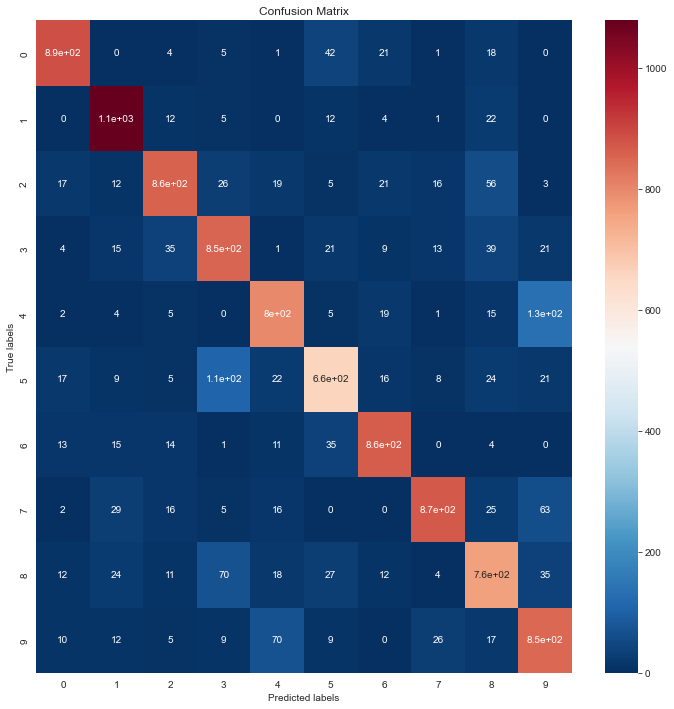

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(12,12))
ax = plt.subplot()
sns.heatmap(confusion_matrix(npzfile['y_test'], classification), cmap='RdBu_r',annot=True, ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

From the confusion matrix reported here, we can see that digit 5 gets often confused by the model, which predicts class 3.

Similarly, patterns belonging to class 4 get often confused with patterns belonging to class 9.

This may be due to the shape of the digit, which is rather similar and can get confused even by humans.
Overall, only with these 2 exceptions, the naive bayes classifier seems to be working well in the considered task.

We can also provide a classification report for each digit, obtaining Precision, Recall and F1-Score for each class.

In [47]:
from sklearn.metrics import classification_report

print(classification_report(npzfile['y_test'], classification))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       980
           1       0.90      0.95      0.92      1135
           2       0.89      0.83      0.86      1032
           3       0.79      0.84      0.81      1010
           4       0.83      0.81      0.82       982
           5       0.81      0.74      0.77       892
           6       0.89      0.90      0.90       958
           7       0.93      0.85      0.89      1028
           8       0.78      0.78      0.78       974
           9       0.76      0.84      0.80      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Something interesting arises from this table: by looking at the classification report here reported, we can observe that besides the digits 3,4,5,9 there's a low f1-score (low when compared to the other digits) associated to digit 8 (78%).

By looking at the confusion matrix, we can in fact see that the digit 8 is quite often confused with other digits, even though this confusion is more widespread: the error is shared among all the other classes.